In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
print("hi")

hi


In [17]:
df = pd.read_csv("marketing_campaign_clean.csv")

print("Shape:", df.shape)
print(df.head())

Shape: (2240, 26)
    Education Marital_Status   Income  Kidhome  Teenhome  Recency  MntWines  \
0  Graduation         Single  58138.0        0         0       58       635   
1  Graduation         Single  46344.0        1         1       38        11   
2  Graduation       Together  71613.0        0         0       26       426   
3  Graduation       Together  26646.0        1         0       26        11   
4         PhD        Married  58293.0        1         0       94       173   

   MntFruits  MntMeatProducts  MntFishProducts  ...  NumWebVisitsMonth  \
0         88              546              172  ...                  7   
1          1                6                2  ...                  5   
2         49              127              111  ...                  4   
3          4               20               10  ...                  6   
4         43              118               46  ...                  5   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  Acc

In [20]:
target = "Response"
y = df[target]
X = df.drop(columns=[target])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [22]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

In [23]:
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

In [24]:
log_reg = Pipeline([
    ("preproc", preproc),
    ("clf", LogisticRegression(max_iter=1000))
])

In [25]:
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       381
           1       0.71      0.37      0.49        67

    accuracy                           0.88       448
   macro avg       0.81      0.67      0.71       448
weighted avg       0.87      0.88      0.87       448

ROC-AUC: 0.8916245543933874


In [27]:
rf = Pipeline([
    ("preproc", preproc),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       381
           1       0.80      0.30      0.43        67

    accuracy                           0.88       448
   macro avg       0.84      0.64      0.69       448
weighted avg       0.88      0.88      0.86       448

ROC-AUC: 0.8782857366709756


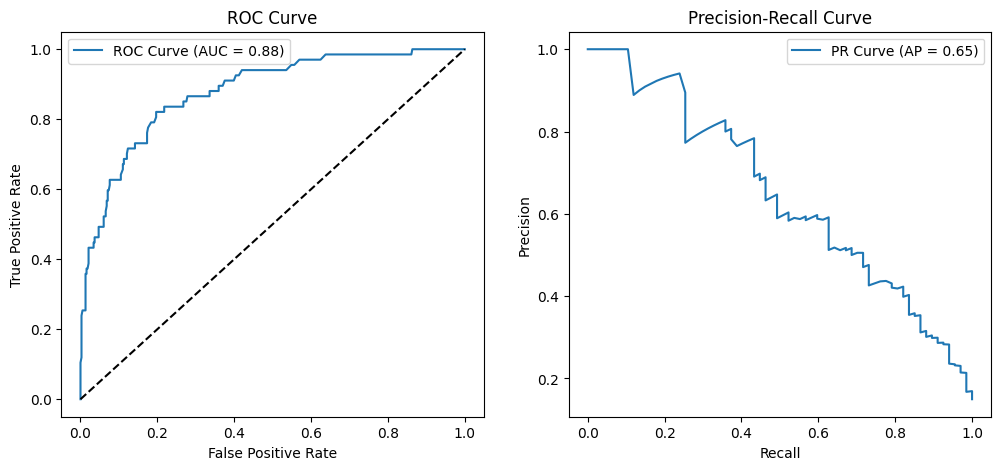

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label="ROC Curve (AUC = %.2f)" % roc_auc_score(y_test, y_prob_rf))
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label="PR Curve (AP = %.2f)" % average_precision_score(y_test, y_prob_rf))
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend()

plt.show()

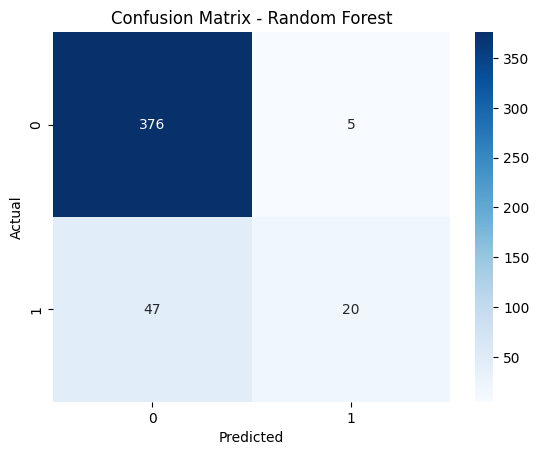

In [30]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

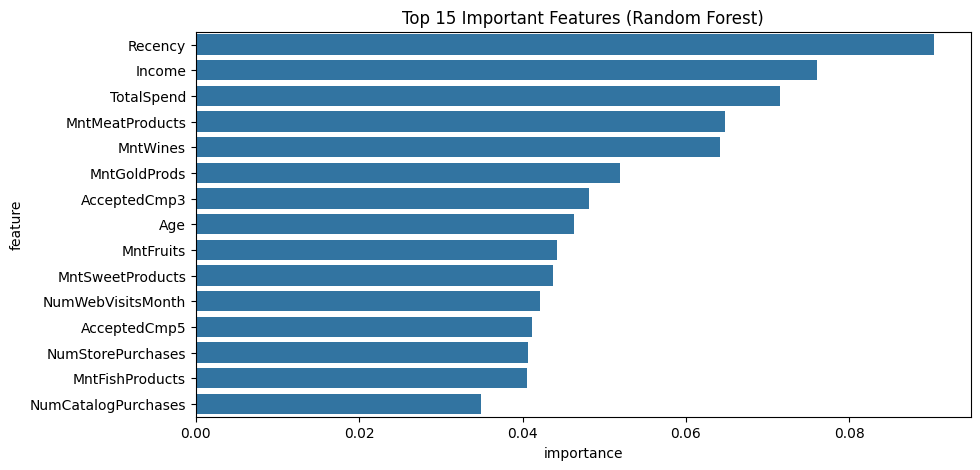

In [31]:
cat_features = rf.named_steps["preproc"].transformers_[1][1].get_feature_names_out(cat_cols)
feat_names = num_cols + list(cat_features)
importances = rf.named_steps["clf"].feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="importance", y="feature", data=fi.head(15))
plt.title("Top 15 Important Features (Random Forest)")
plt.show()